In [ ]:
import os
import json
import shutil

def coco_to_folders(split_dir, output_dir):
    """
    Converts a COCO dataset split into folder structure by category.
    """

    json_path = os.path.join(split_dir, "_annotations.coco.json")
    images_dir = split_dir

    # Load COCO JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    # Map image_id → file name
    id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}

    # Map category_id → category name
    id_to_category = {cat["id"]: cat["name"] for cat in data["categories"]}

    used = set()

    for ann in data["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]

        # Only copy each image once
        if image_id in used:
            continue
        used.add(image_id)

        filename = id_to_filename[image_id]
        category = id_to_category[category_id]

        # Create category folder
        dst_dir = os.path.join(output_dir, category)
        os.makedirs(dst_dir, exist_ok=True)

        src = os.path.join(images_dir, filename)
        dst = os.path.join(dst_dir, filename)

        # Copy image
        shutil.copy(src, dst)

    print(f"Finished processing: {split_dir}")

# ============ CONFIGURE THESE PATHS ============

# Location of your dataset in Drive
# E.g. /content/drive/MyDrive/Brain Tumor MRI Dataset.v1.coco

base_dir = "/content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.coco"

# Where you want the folders
output_base = "/content/drive/MyDrive/brain_tumor_data"

# Process train, valid, test splits
for split in ["train", "valid", "test"]:
    coco_to_folders(
        split_dir=os.path.join(base_dir, split),
        output_dir=os.path.join(output_base, split)
    )


Finished processing: /content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.coco/train
Finished processing: /content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.coco/valid
Finished processing: /content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.coco/test


In [ ]:
import os

In [ ]:
output_base = "/content/drive/MyDrive/brain_tumor_data"

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_base, split)
    if os.path.exists(split_path):
        print(f"\n Contents of {split_path}:")
        print(os.listdir(split_path))
    else:
        print(f" Folder not found: {split_path}")



✅ Contents of /content/drive/MyDrive/brain_tumor_data/train:
['Pituitary', 'Meningioma', 'No Tumor', 'Glioma']

✅ Contents of /content/drive/MyDrive/brain_tumor_data/valid:
['Glioma', 'Pituitary', 'No Tumor', 'Meningioma']

✅ Contents of /content/drive/MyDrive/brain_tumor_data/test:
['Glioma', 'No Tumor', 'Meningioma', 'Pituitary']


In [ ]:
#saving the data fro drive
train_dir = "/content/drive/MyDrive/brain_tumor_data/train"
val_dir = "/content/drive/MyDrive/brain_tumor_data/valid"
test_dir = "/content/drive/MyDrive/brain_tumor_data/test"



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization



In [ ]:
#resizing the image
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
#data augmentation

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


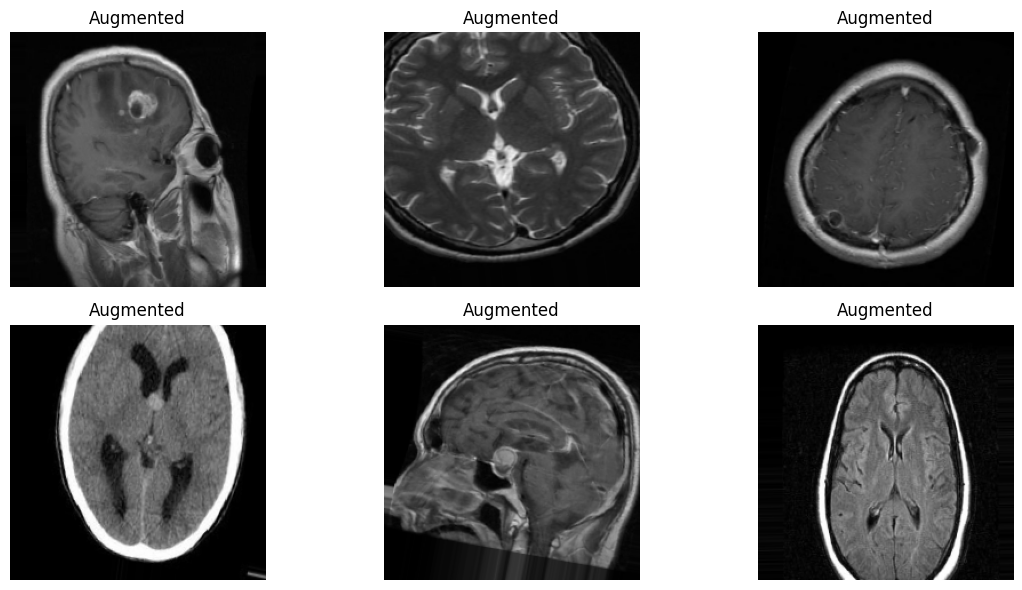

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
data_path = "/content/drive/MyDrive/brain_tumor_data/train"
classes = os.listdir(data_path)
print("Classes:", classes)


Classes: ['Pituitary', 'Meningioma', 'No Tumor', 'Glioma']


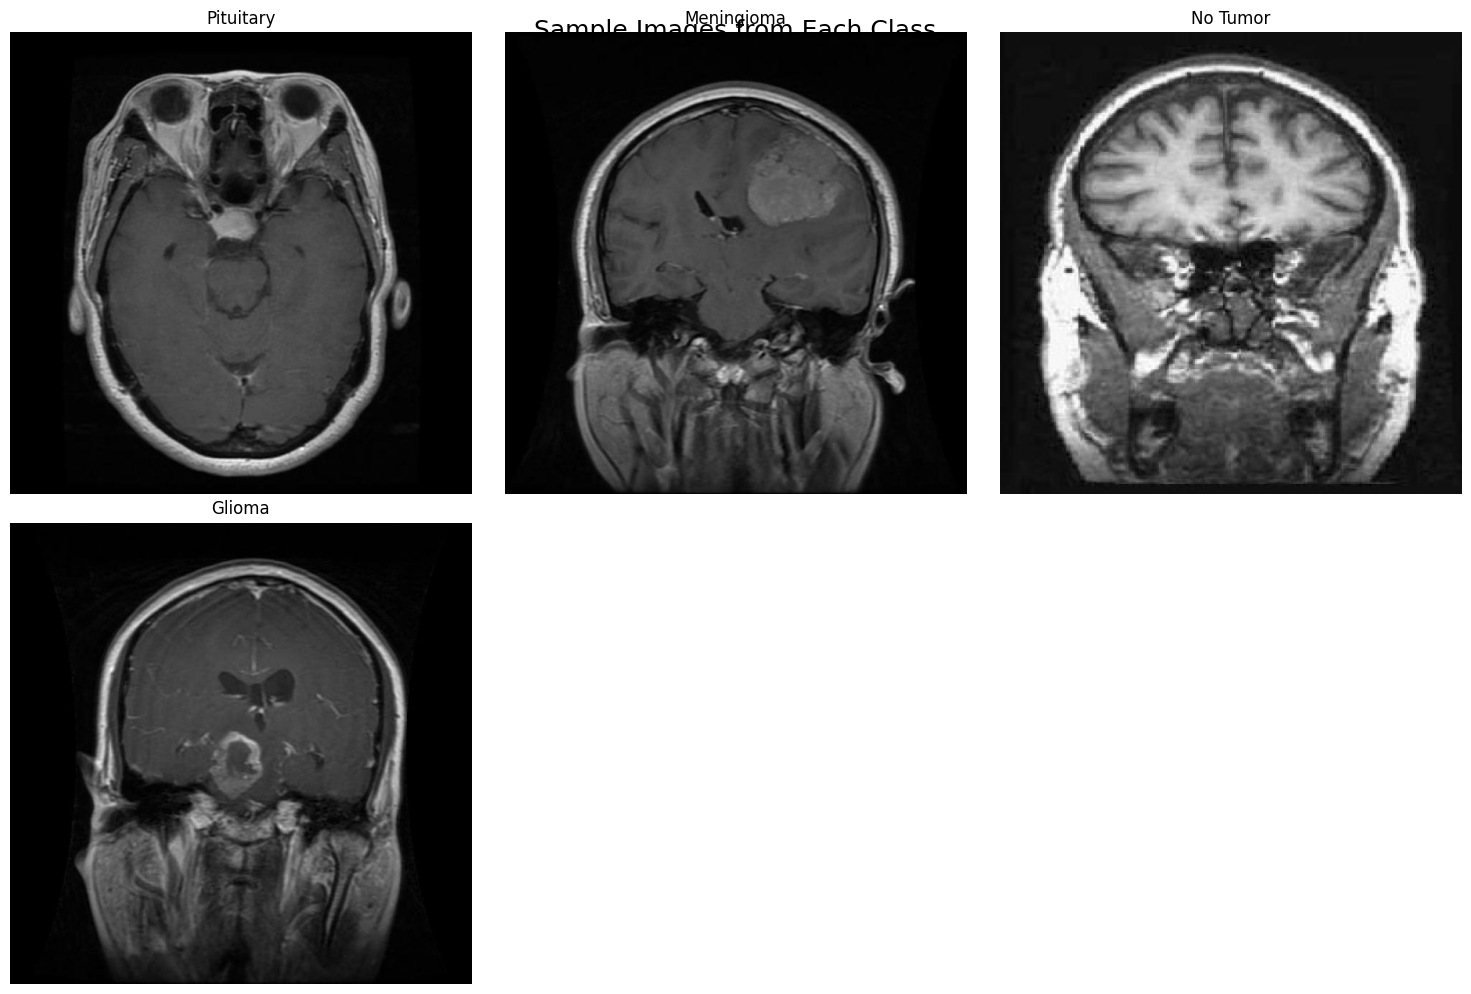

In [ ]:
#Showing some sample Images
plt.figure(figsize=(15, 10))

for i, label in enumerate(classes):
    img_dir = os.path.join(data_path, label)
    img_file = random.choice(os.listdir(img_dir))
    img_path = os.path.join(img_dir, img_file)

    img = mpimg.imread(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Images from Each Class", fontsize=18)
plt.show()


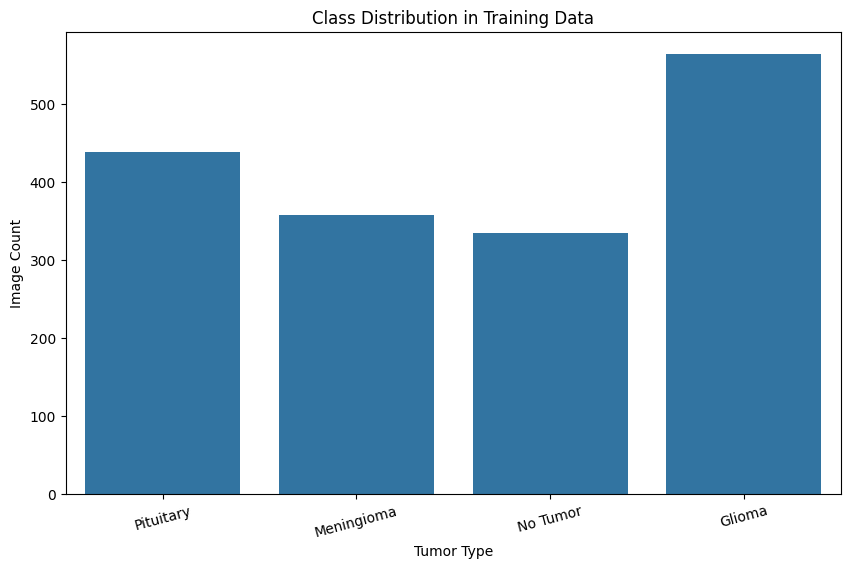

In [ ]:
import pandas as pd
import seaborn as sns

labels_count = {}
for cls in classes:
    labels_count[cls] = len(os.listdir(os.path.join(train_dir, cls)))

df = pd.DataFrame(list(labels_count.items()), columns=["Tumor Type", "Image Count"])

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="Tumor Type", y="Image Count")
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=15)
plt.show()

**Custom CNN**

In [ ]:
num_classes = len(train_gen.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/custom_model_best.h5"

#callback function
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor='val_loss'
    )
]


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get labels from train generator
labels = train_gen.classes  # integer encoded class labels (e.g., 0, 1, 2, 3)

# Get class names (dict)
class_indices = train_gen.class_indices
class_names = list(class_indices.keys())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict (required by Keras)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


In [ ]:
#training the Custom CNN model
history = model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weights,callbacks=callbacks)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.3229 - loss: 1.5968

53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 649ms/step - accuracy: 0.3244 - loss: 1.5921 - val_accuracy: 0.6394 - val_loss: 0.9474
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5530 - loss: 1.1113

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 671ms/step - accuracy: 0.5538 - loss: 1.1102 - val_accuracy: 0.6175 - val_loss: 0.9062
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6354 - loss: 0.9213

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 650ms/step - accuracy: 0.6359 - loss: 0.9204 - val_accuracy: 0.7709 - val_loss: 0.6803
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - accuracy: 0.6834 - loss: 0.8208 - val_accuracy: 0.7430 - val_loss: 0.7431
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7307 - loss: 0.7403

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.7308 - loss: 0.7403 - val_accuracy: 0.7610 - val_loss: 0.6408
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.7429 - loss: 0.6932

53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 672ms/step - accuracy: 0.7430 - loss: 0.6933 - val_accuracy: 0.7689 - val_loss: 0.6235
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7389 - loss: 0.6675

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 659ms/step - accuracy: 0.7389 - loss: 0.6677 - val_accuracy: 0.7968 - val_loss: 0.5445
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7458 - loss: 0.6444

53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.7460 - loss: 0.6444 - val_accuracy: 0.8068 - val_loss: 0.5112
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 617ms/step - accuracy: 0.7770 - loss: 0.5964 - val_accuracy: 0.6853 - val_loss: 0.7798
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.7331 - loss: 0.6418 - val_accuracy: 0.7689 - val_loss: 0.6092
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - accuracy: 0.7917 - loss: 0.5864 - val_accuracy: 0.8088 - val_loss: 0.5188
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7811 - loss: 0.5763

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.7810 - loss: 0.5765 - val_accuracy: 0.8048 - val_loss: 0.4966
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7842 - loss: 0.5603

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 661ms/step - accuracy: 0.7844 - loss: 0.5601 - val_accuracy: 0.8386 - val_loss: 0.4628
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7744 - loss: 0.6282

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 670ms/step - accuracy: 0.7746 - loss: 0.6273 - val_accuracy: 0.8247 - val_loss: 0.4406
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.8139 - loss: 0.5379 - val_accuracy: 0.7869 - val_loss: 0.5260
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 556ms/step - accuracy: 0.7874 - loss: 0.5694 - val_accuracy: 0.8167 - val_loss: 0.4751
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.7949 - loss: 0.5279 - val_accuracy: 0.8287 - val_loss: 0.4446
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.8273 - loss: 0.4830 - val_accuracy: 0.7988 - val_loss: 0.5242
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.8075 - loss: 0.4982 - val_accuracy: 0.8147 - val_loss: 0.4911


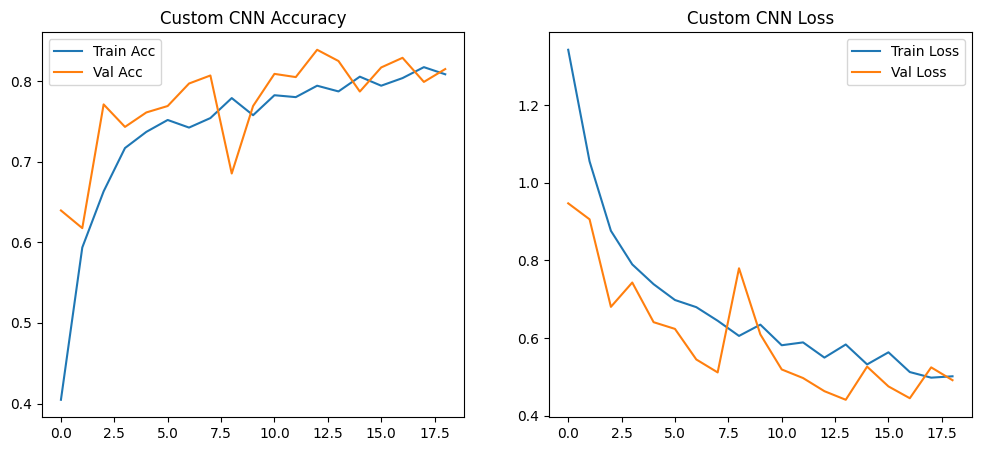

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Custom CNN Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Custom CNN Loss")
plt.legend()

plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
              precision    recall  f1-score   support

      Glioma       0.96      0.86      0.91        80
  Meningioma       0.85      0.62      0.72        63
    No Tumor       0.76      0.96      0.85        49
   Pituitary       0.79      0.96      0.87        54

    accuracy                           0.84       246
   macro avg       0.84      0.85      0.83       246
weighted avg       0.85      0.84      0.84       246



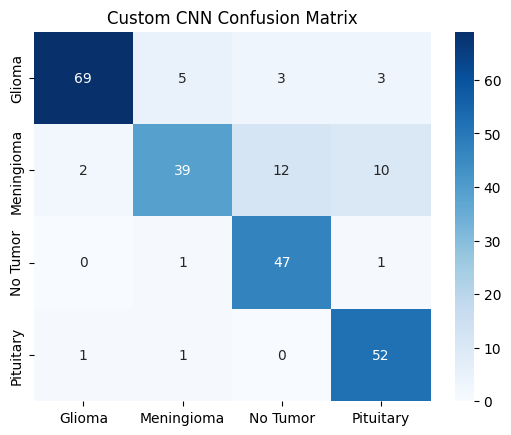

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Custom CNN Confusion Matrix")
plt.show()


# Transfer Learning

In [ ]:


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import os



**ResNet50**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze base

for layer in base_model.layers[:-100]:
    layer.trainable = False



In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/brain_tumor_resnet50_best.h5"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 22,414,724 (85.51 MB)

 Non-trainable params: 1,435,776 (5.48 MB)

In [ ]:
#training ResNet50
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.3317 - loss: 1.4972

53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.3330 - loss: 1.4950 - val_accuracy: 0.1972 - val_loss: 1.5478 - learning_rate: 1.0000e-05
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 630ms/step - accuracy: 0.4839 - loss: 1.2386 - val_accuracy: 0.2590 - val_loss: 1.5573 - learning_rate: 1.0000e-05
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5801 - loss: 1.0390

53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 709ms/step - accuracy: 0.5801 - loss: 1.0390 - val_accuracy: 0.1912 - val_loss: 1.4702 - learning_rate: 1.0000e-05
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.6280 - loss: 0.9226

53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 880ms/step - accuracy: 0.6278 - loss: 0.9228 - val_accuracy: 0.3785 - val_loss: 1.2410 - learning_rate: 1.0000e-05
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.6182 - loss: 0.9355

53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 904ms/step - accuracy: 0.6184 - loss: 0.9349 - val_accuracy: 0.5876 - val_loss: 0.9825 - learning_rate: 1.0000e-05
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6591 - loss: 0.8675

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 843ms/step - accuracy: 0.6593 - loss: 0.8672 - val_accuracy: 0.7092 - val_loss: 0.7761 - learning_rate: 1.0000e-05
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6588 - loss: 0.8197

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 811ms/step - accuracy: 0.6591 - loss: 0.8196 - val_accuracy: 0.7430 - val_loss: 0.6903 - learning_rate: 1.0000e-05
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.6805 - loss: 0.7770

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 843ms/step - accuracy: 0.6805 - loss: 0.7770 - val_accuracy: 0.7789 - val_loss: 0.6288 - learning_rate: 1.0000e-05
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7105 - loss: 0.7393

53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 867ms/step - accuracy: 0.7103 - loss: 0.7396 - val_accuracy: 0.7709 - val_loss: 0.6254 - learning_rate: 1.0000e-05
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7206 - loss: 0.7163

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 820ms/step - accuracy: 0.7207 - loss: 0.7161 - val_accuracy: 0.7809 - val_loss: 0.5806 - learning_rate: 1.0000e-05


In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7532 - loss: 0.6089
Test Accuracy: 0.7967


In [ ]:
#making the comparison between Custom CNN and Resnet50

import pandas as pd

# Define performance data
comparison_data = {
    "Model": ["Custom CNN", "ResNet50 (Fine-Tuned)"],
    "Train Accuracy": [0.91, 0.721],
    "Validation Accuracy": [0.88, 0.781],
    "Test Accuracy": [0.78, 0.797],
    "Loss": ["Lower train loss", "Better generalization"],
    "Overfitting Risk": ["High", "Low"],
    "Transfer Learning": ["No", "Yes"],
    "Fine-Tuning": ["Not Applicable", "Unfrozen Top 100 Layers"]
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display table
from IPython.display import display
display(comparison_df)


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Loss,Overfitting Risk,Transfer Learning,Fine-Tuning
0,Custom CNN,0.910,0.880,0.780,Lower train loss,High,No,Not Applicable
1,ResNet50 (Fine-Tuned),0.721,0.781,0.797,Better generalization,Low,Yes,Unfrozen Top 100 Layers


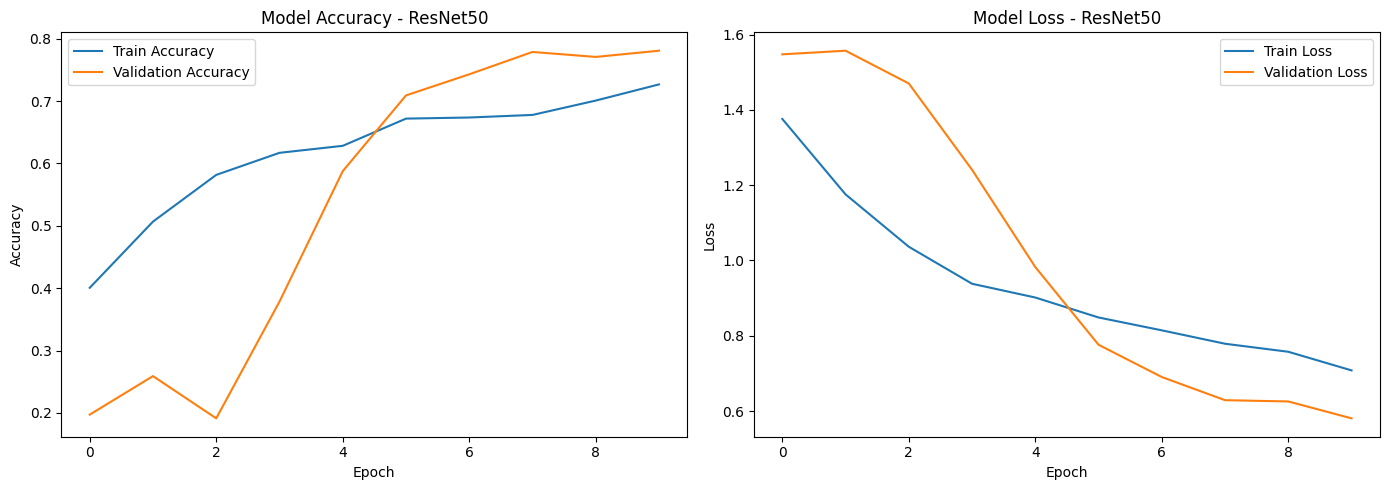

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy - ResNet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - ResNet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 740ms/step
              precision    recall  f1-score   support

      Glioma       0.84      0.81      0.83        80
  Meningioma       0.72      0.54      0.62        63
    No Tumor       0.79      0.92      0.85        49
   Pituitary       0.80      0.96      0.87        54

    accuracy                           0.80       246
   macro avg       0.79      0.81      0.79       246
weighted avg       0.79      0.80      0.79       246



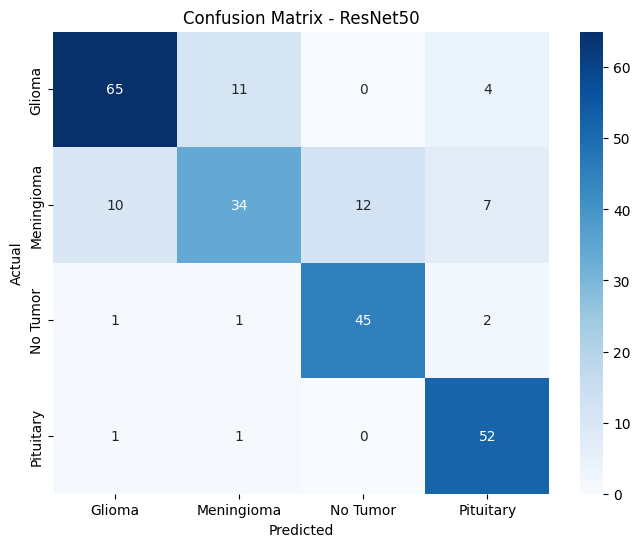

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predictions
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os


**DenseNet121**

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze base layers

for layer in base_model.layers[:-100]:  # Freeze up to last 100 layers
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,220 (27.35 MB)

 Trainable params: 2,080,324 (7.94 MB)

 Non-trainable params: 5,088,896 (19.41 MB)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/brain_tumor_densenet_best.h5"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


In [ ]:
#training DenseNet121
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.3362 - loss: 2.0586

53/53 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3364 - loss: 2.0575 - val_accuracy: 0.3267 - val_loss: 1.6317 - learning_rate: 1.0000e-05
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.4147 - loss: 1.6534

53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 676ms/step - accuracy: 0.4149 - loss: 1.6526 - val_accuracy: 0.4343 - val_loss: 1.1124 - learning_rate: 1.0000e-05
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.4788 - loss: 1.4179

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - accuracy: 0.4788 - loss: 1.4174 - val_accuracy: 0.6056 - val_loss: 0.8671 - learning_rate: 1.0000e-05
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5121 - loss: 1.2547

53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 636ms/step - accuracy: 0.5124 - loss: 1.2545 - val_accuracy: 0.6952 - val_loss: 0.7251 - learning_rate: 1.0000e-05
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5636 - loss: 1.1100

53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 632ms/step - accuracy: 0.5637 - loss: 1.1103 - val_accuracy: 0.7629 - val_loss: 0.6441 - learning_rate: 1.0000e-05
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6172 - loss: 1.0359

53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.6172 - loss: 1.0355 - val_accuracy: 0.7948 - val_loss: 0.5898 - learning_rate: 1.0000e-05
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6282 - loss: 0.9648

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step - accuracy: 0.6283 - loss: 0.9648 - val_accuracy: 0.8127 - val_loss: 0.5554 - learning_rate: 1.0000e-05
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6399 - loss: 0.9744

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 635ms/step - accuracy: 0.6400 - loss: 0.9743 - val_accuracy: 0.8207 - val_loss: 0.5270 - learning_rate: 1.0000e-05
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6613 - loss: 0.9103

53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 689ms/step - accuracy: 0.6614 - loss: 0.9098 - val_accuracy: 0.8207 - val_loss: 0.5040 - learning_rate: 1.0000e-05
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6821 - loss: 0.8409

53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 638ms/step - accuracy: 0.6825 - loss: 0.8405 - val_accuracy: 0.8287 - val_loss: 0.4851 - learning_rate: 1.0000e-05


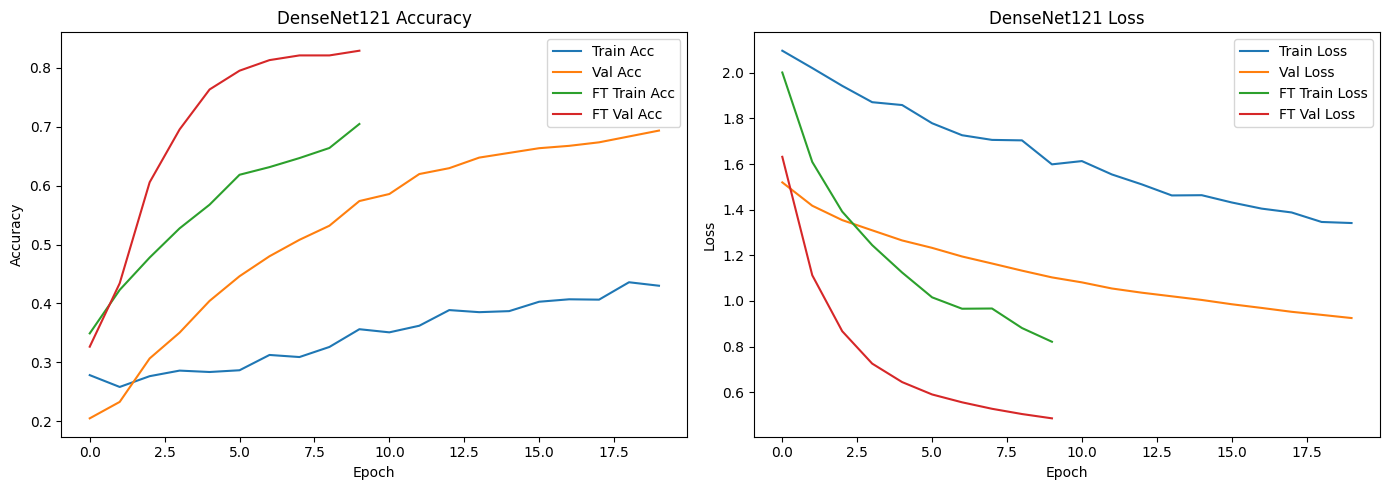

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Train Acc')
plt.plot(history_densenet.history['val_accuracy'], label='Val Acc')
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='FT Train Acc')
    plt.plot(history.history['val_accuracy'], label='FT Val Acc')
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Val Loss')
if 'loss' in history.history:
    plt.plot(history.history['loss'], label='FT Train Loss')
    plt.plot(history.history['val_loss'], label='FT Val Loss')
plt.title("DenseNet121 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 19s/step

📄 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.91      0.88      0.89        80
  Meningioma       0.67      0.57      0.62        63
    No Tumor       0.95      0.73      0.83        49
   Pituitary       0.68      0.96      0.79        54

    accuracy                           0.79       246
   macro avg       0.80      0.79      0.78       246
weighted avg       0.80      0.79      0.79       246



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


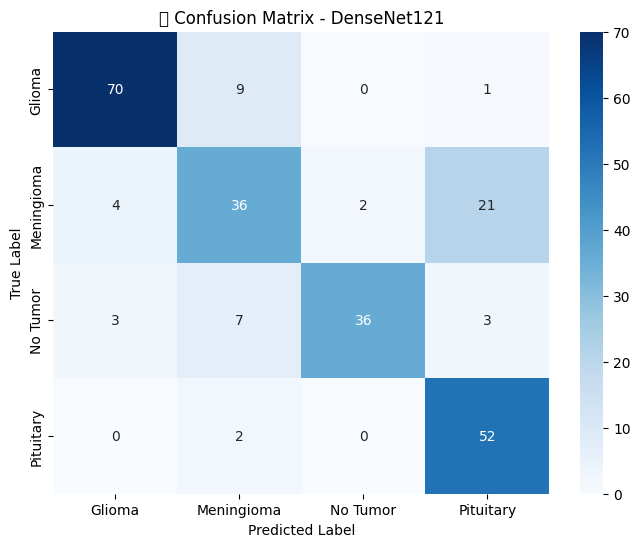

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predictions
y_pred_probs = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧠 Confusion Matrix - DenseNet121")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
loss, acc = model.evaluate(test_gen)
print(f" Final Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7887 - loss: 0.5140
 Final Test Accuracy: 0.7886 | Test Loss: 0.5387


In [ ]:
#comparison between Custom CNN ,ResNet50 and DenseNet121
import pandas as pd
from IPython.display import display

# Final accuracy and metadata
comparison_data = {
    "Model": ["Custom CNN", "ResNet50 (FT)", "DenseNet121 (FT)"],
    "Train Accuracy": [0.91, 0.721, 0.683],
    "Validation Accuracy": [0.88, 0.781, 0.829],
    "Test Accuracy": [0.78, 0.797, 0.7886],
    "Train Loss": ["Low", "Moderate", "Moderate"],
    "Validation Loss": ["Low", "Balanced", "Low"],
    "Overfitting Risk": ["High", "Low", "Low"],
    "Transfer Learning": ["No", "Yes", "Yes"],
    "Fine-Tuning": ["N/A", "Top 100 layers", "Top 100 layers"],
    "Generalization": ["Moderate", "Good", "Very Good"]
}

# Create and display dataframe
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)



,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Overfitting Risk,Transfer Learning,Fine-Tuning,Generalization
0,Custom CNN,0.910,0.880,0.7800,Low,Low,High,No,N/A,Moderate
1,ResNet50 (FT),0.721,0.781,0.7970,Moderate,Balanced,Low,Yes,Top 100 layers,Good
2,DenseNet121 (FT),0.683,0.829,0.7886,Moderate,Low,Low,Yes,Top 100 layers,Very Good


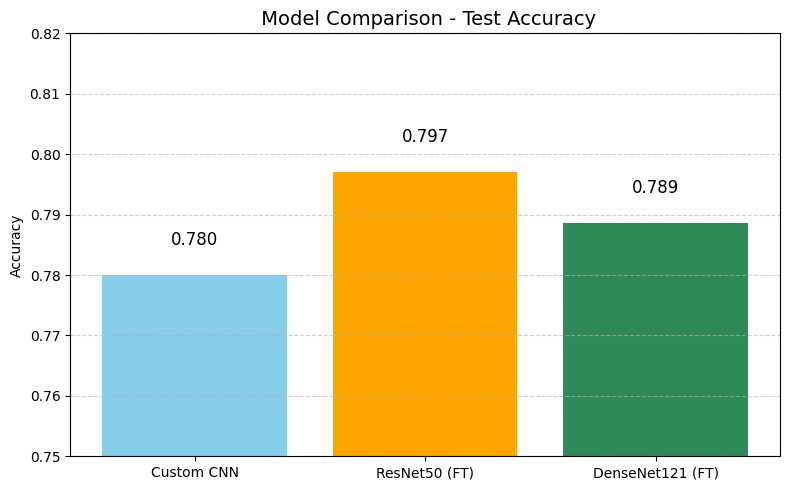

In [ ]:
#plot showing the comparisons

import matplotlib.pyplot as plt

# Accuracy values
models = ['Custom CNN', 'ResNet50 (FT)', 'DenseNet121 (FT)']
test_accuracies = [0.78, 0.797, 0.7886]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(models, test_accuracies, color=['skyblue', 'orange', 'seagreen'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}",
             ha='center', fontsize=12)

plt.title(" Model Comparison - Test Accuracy", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0.75, 0.82)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import  ReduceLROnPlateau

**EfficientNetB0**

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze for now
for layer in base_model.layers[:-100]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 3,642,616 (13.90 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("efficientnetb0_best.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


In [ ]:
#training EfficientNetB0
history_effnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.2931 - loss: 1.4295

53/53 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2935 - loss: 1.4289 - val_accuracy: 0.3207 - val_loss: 1.3849 - learning_rate: 1.0000e-04
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.3842 - loss: 1.3261

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 578ms/step - accuracy: 0.3845 - loss: 1.3257 - val_accuracy: 0.3207 - val_loss: 1.3811 - learning_rate: 1.0000e-04
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4059 - loss: 1.2679

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 572ms/step - accuracy: 0.4059 - loss: 1.2678 - val_accuracy: 0.3207 - val_loss: 1.3807 - learning_rate: 1.0000e-04
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 565ms/step - accuracy: 0.4297 - loss: 1.2499 - val_accuracy: 0.3207 - val_loss: 1.3953 - learning_rate: 1.0000e-04
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.4626 - loss: 1.2080 - val_accuracy: 0.3207 - val_loss: 1.3964 - learning_rate: 1.0000e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4747 - loss: 1.1849

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 578ms/step - accuracy: 0.4751 - loss: 1.1841 - val_accuracy: 0.3307 - val_loss: 1.3460 - learning_rate: 2.0000e-05
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.4882 - loss: 1.1351

53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 570ms/step - accuracy: 0.4881 - loss: 1.1354 - val_accuracy: 0.3884 - val_loss: 1.2712 - learning_rate: 2.0000e-05
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.5068 - loss: 1.1227

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.5065 - loss: 1.1233 - val_accuracy: 0.5817 - val_loss: 1.1327 - learning_rate: 2.0000e-05
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 551ms/step - accuracy: 0.5023 - loss: 1.1142 - val_accuracy: 0.4622 - val_loss: 1.1803 - learning_rate: 2.0000e-05
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.5044 - loss: 1.1232

53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - accuracy: 0.5045 - loss: 1.1229 - val_accuracy: 0.6912 - val_loss: 1.0612 - learning_rate: 2.0000e-05


In [ ]:
loss, acc = model.evaluate(test_gen)
print(f" EfficientNetB0 Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7065 - loss: 1.0881
 EfficientNetB0 Test Accuracy: 0.7154 | Test Loss: 1.0479


In [ ]:
#comparisons between Custom CNN", "ResNet50 (FT)", "DenseNet121 (FT)", "EfficientNetB0 (FT)
import pandas as pd
from IPython.display import display

# Define comparison data
comparison_data = {
    "Model": ["Custom CNN", "ResNet50 (FT)", "DenseNet121 (FT)", "EfficientNetB0 (FT)"],
    "Train Accuracy": [0.91, 0.721, 0.683, 0.504],
    "Validation Accuracy": [0.88, 0.781, 0.829, 0.691],
    "Test Accuracy": [0.78, 0.797, 0.7886, 0.7154],
    "Train Loss": ["Low", "Moderate", "Moderate", "High"],
    "Validation Loss": ["Low", "Balanced", "Low", "High"],
    "Overfitting Risk": ["High", "Low", "Low", "Low"],
    "Transfer Learning": ["No", "Yes", "Yes", "Yes"],
    "Fine-Tuning": ["N/A", "Top 100 layers", "Top 100 layers", "Top 100 layers"],
    "Generalization": ["Moderate", "Good", "Very Good", "Fair"]
}

# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table
display(comparison_df)


,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Overfitting Risk,Transfer Learning,Fine-Tuning,Generalization
0,Custom CNN,0.910,0.880,0.7800,Low,Low,High,No,N/A,Moderate
1,ResNet50 (FT),0.721,0.781,0.7970,Moderate,Balanced,Low,Yes,Top 100 layers,Good
2,DenseNet121 (FT),0.683,0.829,0.7886,Moderate,Low,Low,Yes,Top 100 layers,Very Good
3,EfficientNetB0 (FT),0.504,0.691,0.7154,High,High,Low,Yes,Top 100 layers,Fair


/tmp/ipython-input-56-1324453520.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


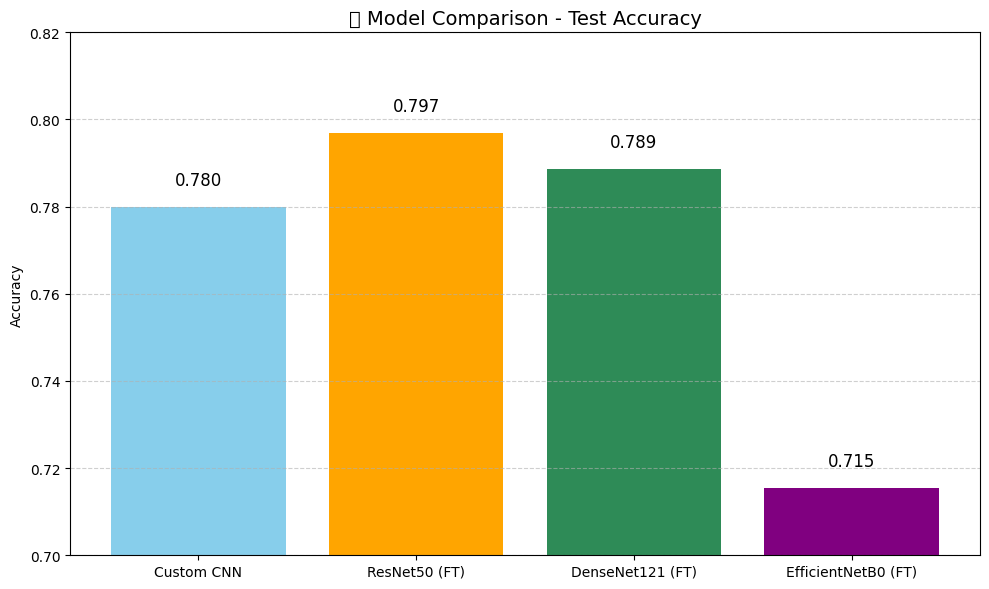

In [ ]:
#plot for the comparisons
import matplotlib.pyplot as plt

models = ['Custom CNN', 'ResNet50 (FT)', 'DenseNet121 (FT)', 'EfficientNetB0 (FT)']
test_accuracies = [0.78, 0.797, 0.7886, 0.7154]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_accuracies, color=['skyblue', 'orange', 'seagreen', 'purple'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}",
             ha='center', fontsize=12)

plt.title("📊 Model Comparison - Test Accuracy", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0.7, 0.82)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


/tmp/ipython-input-60-3900097150.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-60-3900097150.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


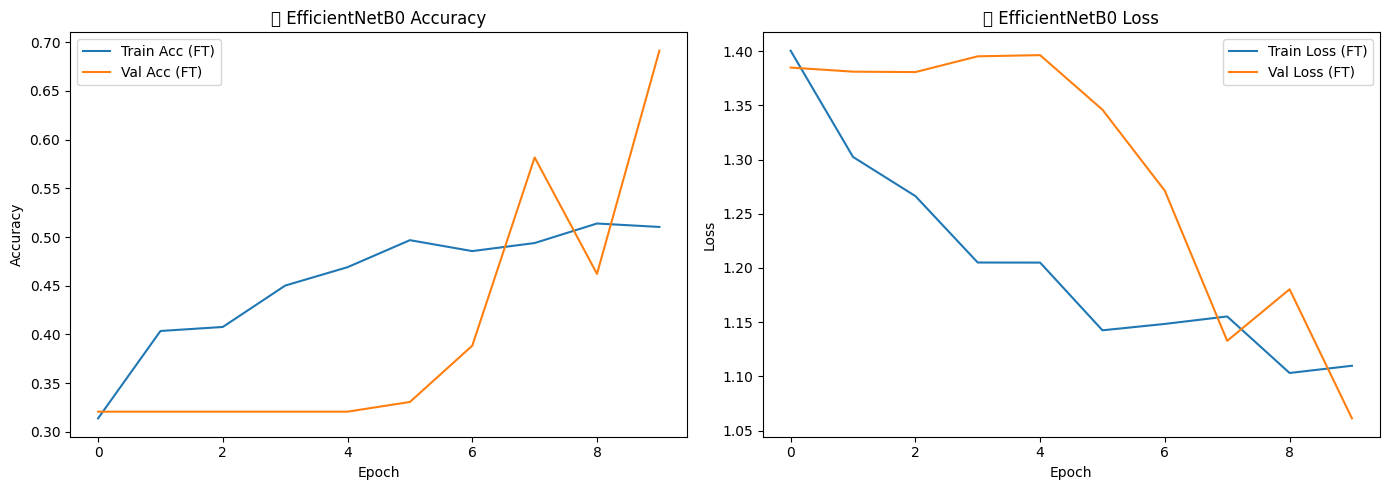

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

plt.plot(history_effnet.history['accuracy'], label='Train Acc (FT)')
plt.plot(history_effnet.history['val_accuracy'], label='Val Acc (FT)')
plt.title("📈 EfficientNetB0 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)

plt.plot(history_effnet.history['loss'], label='Train Loss (FT)')
plt.plot(history_effnet.history['val_loss'], label='Val Loss (FT)')
plt.title("📉 EfficientNetB0 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
📄 Classification Report:

              precision    recall  f1-score   support

      Glioma       0.80      0.75      0.77        80
  Meningioma       0.58      0.59      0.58        63
    No Tumor       0.59      0.71      0.65        49
   Pituitary       0.92      0.81      0.86        54

    accuracy                           0.72       246
   macro avg       0.72      0.72      0.72       246
weighted avg       0.73      0.72      0.72       246



/tmp/ipython-input-59-3850090039.py:24: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


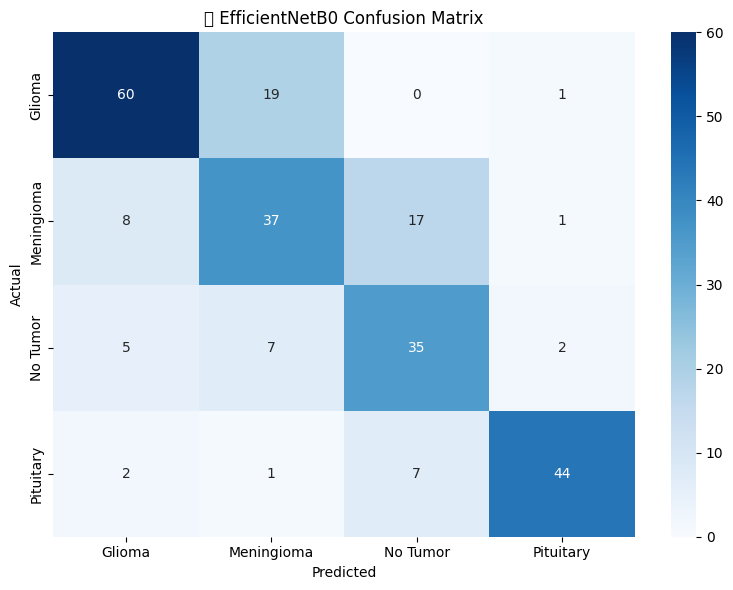

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predictions
y_pred_probs = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# 📄 Classification Report
print("📄 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧠 EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
